In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import os
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from itertools import combinations
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib import pyplot as plt



In [2]:
import fbprophet
p = fbprophet
print(p.__version__)

0.7.1


In [3]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
daily = pd.read_csv('/home/angarmin/Desktop/timeseries_lab/angela_garcia/data/pm_daily.csv')
weekly = pd.read_csv('/home/angarmin/Desktop/timeseries_lab/angela_garcia/data/pm_weekly.csv')
#daily.set_index('date', inplace=True)
#weekly.set_index('date', inplace=True)

daily=daily.iloc[1:]  ###quito la 1a fila de NA en trend
weekly=weekly.iloc[1:]  ###quito la 1a fila de NA en trend

# FUNCTIONS



In [5]:
def train_test_split(df, start_test_date="2015-01-01", end_test_date="2015-07-01",date_col="date"):
    '''
    start_test_date
    end_test_date -> date where test ends, (we leave apart data for posterior validation)
    '''
    
    train= df[df[date_col]<start_test_date]
    test= df[(df[date_col]>=start_test_date)&(df[date_col]<end_test_date)]
    
    return train, test

    

In [6]:
def score_metric(y_true,y_pred, metric="mae"):
    "metric= mae/rmse/mape"
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    if metric=="mae":
        return mean_absolute_error(y_pred, y_true)
    elif metric=="rmse":
        return(np.sqrt(mean_squared_error(y_pred, y_true)))
    elif metric=="mape":   
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def prophet_search(df, y_col ,date_col,start_test_date, end_test_date,reg_cols=[] ):
    
    df = df.rename(columns={'date':'ds', y_col: 'y'})
    train, test= train_test_split(df,date_col="ds")    
    
    params_grid = {'growth':('linear','flat'), #logistic, flat
                   'changepoint_prior_scale':[0.3, 0.7],
                   'yearly_seasonality': (True,), #auto, False, comprobada mejor true
                   #'seasonality.mode' : ('multiplicative', 'additive'),
                   'changepoint_range':[0.95,0.8]}
    grid = ParameterGrid(params_grid) 
   
    variables_comb = sum([list(map(list, combinations(reg_cols, i))) for i in range(len(reg_cols) + 1)], [])
    #combinaciones de posibles variables
    
    score=-1
    for p in grid:    ##bcle que corre sobre todo el grid y todas las combinaciones de variables
        for variables in variables_comb: 
            m =Prophet(**p)
            if variables !=[]:
                for regressor in variables: 
                    m.add_regressor(regressor, standardize=False) ###mode, es el mismo que seasonality mode

            m.fit(train)
            y_pred=m.predict(test)  
            score_inter=score_metric(test["y"],y_pred.yhat)

            if score ==  -1 or score_inter < score: ##se queda con el mejor score
                score = score_inter
                model_selec= m
                hyperp_selec= p
                variables_selec=variables
            
            #print(score_metric(test["y"],y_pred.yhat, metric= "mape"))
            #print(p,m,variables)
    return(model_selec,hyperp_selec,variables_selec)

            
            ## añadir más parametros al grid
            ## y cambiar nombres ej ycol -> pm_centro 

In [8]:
def sarimax_search(df, y_col ,date_col,start_test_date, end_test_date,reg_cols=[], S=365 ):
  
    df = df.rename(columns={'date':'ds', y_col: 'y'})
    train, test= train_test_split(df,date_col="ds")    
    

    order_comb = list(product([0,1],[0,1],[0,1]))
    seasonal_order_comb= list(product([0,1],[0,1],[0,1],[S])) ## posibles combinaciones 'pdq'
    
    params_grid = {'order':order_comb, 
                   'seasonal_order':seasonal_order_comb                  
                  }
    
    grid = ParameterGrid(params_grid) 
   
    variables_comb = sum([list(map(list, combinations(reg_cols, i))) for i in range(len(reg_cols) + 1)], [])
    #combinaciones de posibles variables
    
    score=-1
    ##copiado ¿?
    # I know this seems like a lot, but to be able to support broken time series in the forecast you need to reset the indexes

    test_aux = test.copy(deep=True)

    # TODO: remove this parameter
    #test_aux[xreg]=np.exp(test_aux[xreg])
    #test_aux[xreg]=test_aux[xreg]*0.9
    #test_aux[xreg]=np.log(test_aux[xreg])

    test_aux.reset_index(drop=True, inplace=True)
    train_aux = train.copy(deep=True)
    train_aux.reset_index(drop=True, inplace=True)
    
    ### lo he dejado así para que no tarde tanto. CAMBIAR. 
    variables_comb=[['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']]
                   
    for p in grid:    ##bcle que corre sobre todo el grid y todas las combinaciones de variables
        for variables in variables_comb: 
            
            print("p",p)
            print("variables",variables)
                  
            if variables !=[]:
                m = SARIMAX(train["y"], exog=train[variables],**p).fit()
              #  y_pred=m.predict(start=test.index[0],end=test.index[-1],exog=test[variables]) 
                y_pred=m.predict(train_aux.index.max() + 1, end=train_aux.index.max() + 1 + test_aux.index.max(), exog=test_aux[variables])
                
               # y_pred=m.predict(start=test.index[0],end=test.index[-1],exog=pd.concat([pd.DataFrame(train[variables].iloc[-1], columns=variables), test[variables]])) 
            else: 
                m = SARIMAX(train["y"],**p).fit()
                y_pred=m.predict(train_aux.index.max() + 1, end=train_aux.index.max() + 1 + test_aux.index.max())
            y_pred.index = test.index
            score_inter=score_metric(test["y"],y_pred)

            if score ==  -1 or score_inter < score: ##se queda con el mejor score
                score = score_inter
                model_selec= m
                hyperp_selec= p
                variables_selec=variables

            print("hyperp_selec",hyperp_selec)
            print("variables_selec",variables_selec)
           
            #print(score_metric(test["y"],y_pred.yhat, metric= "mape"))
            #print(p,m,variables)
    return(model_selec,hyperp_selec,variables_selec)

            
            ## añadir más parametros al grid
            ## y cambiar nombres ej ycol -> pm_centro 


In [73]:
def walkforward(df, y_col ,date_col, start_validation_date, test_size =15, reg_cols=[],model="Prophet",hyperp={},regr=[]):
    
    n_steps=int(df[df[date_col] >= start_validation_date].shape[0]/test_size)
    
    df = df.rename(columns={'date':'ds', y_col: 'y'})

        
    df=df.append(pd.Series(), ignore_index=True) ##esto es una fil de nans para luego coger bien la ukltima en la lista de debajo 
    test=[df.iloc[-test_size*(step+1)-1:-test_size*step-1] for step in range(n_steps)]
    train=[df.iloc[:-test_size*(step+1)-1] for step in range(n_steps)]
    
    test=test[::-1]
    train=train[::-1] # reordenarla

    mae=[]
    rmse=[]
    mape=[]
    y_pred_comp=[]
 
    for slot in range(len(train)):
        if model==  "Prophet":
            m = Prophet(**hyperp)
            if regr !=[]:
                for regressor in regr:  
                    m.add_regressor(regressor, standardize=False)
            m.fit(train[slot])
            y_pred=m.predict(test[slot]) 
            y_pred= y_pred.yhat
            
        elif model =="SARIMAX":

            test_aux = test[slot].copy(deep=True)
            test_aux.reset_index(drop=True, inplace=True)
            train_aux = train[slot].copy(deep=True)
            train_aux.reset_index(drop=True, inplace=True)
    
            if regr !=[]:
                m = SARIMAX(train[slot]["y"], exog=train[slot][regr],**hyperp).fit()
                y_pred=m.predict(train_aux.index.max() + 1, end=train_aux.index.max() + 1 + test_aux.index.max(), exog=test_aux[regr])
            else: 
                m = SARIMAX(train[slot]["y"],**hyperp).fit()
                y_pred=m.predict(train_aux.index.max() + 1, end=train_aux.index.max() + 1 + test_aux.index.max())
                y_pred.index = test.index
        
        y_pred_comp.append(y_pred)       
        mae.append(score_metric(test[slot]["y"],y_pred, metric="mae"))
        rmse.append(score_metric(test[slot]["y"],y_pred, metric="rmse"))
        mape.append(score_metric(test[slot]["y"],y_pred, metric="mape"))

    y_pred_comp=[item for sublist in y_pred_comp for item in sublist] 
    test_comp=pd.concat(test)
    return(y_pred_comp,test_comp,mae, rmse, mape)
  
'''    plt.figure(figsize=(15,4)) ###ploteo solo el ultimo caso (cuando entrena con más datos)
    plt.plot(test_comp["ds"] ,test_comp["y"], label='Actual')
    plt.plot(test_comp["ds"], y_pred_comp, label='Predicted')
    plt.legend()
    plt.show()'''



'    plt.figure(figsize=(15,4)) ###ploteo solo el ultimo caso (cuando entrena con más datos)\n    plt.plot(test_comp["ds"] ,test_comp["y"], label=\'Actual\')\n    plt.plot(test_comp["ds"], y_pred_comp, label=\'Predicted\')\n    plt.legend()\n    plt.show()'

# RESULTADOS DAILY

In [ ]:
#model_SARIMAX,hyperp_SARIMAX,=sarimax_search(df=daily,y_col="PM_CENTRO",date_col="date",reg_cols=["DEW_POINT","HUMIDITY","TEMPERATURE","WIND_SPEED"] , start_test_date="2015-01-01", end_test_date="2015-07-01", S=365)
#PRUEBA
hyperp_SARIMAX={'order': (0, 0, 0), 'seasonal_order': (0, 0, 1, 365)}
variables_SARIMAX=['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


In [ ]:
#model_Prophet,hyperp_Prophet,variables_Prophet=prophet_search(df=daily,y_col="PM_CENTRO",date_col="date",reg_cols=["DEW_POINT","HUMIDITY","TEMPERATURE","WIND_SPEED"] , start_test_date="2015-01-01", end_test_date="2015-07-01")
#resultado 
hyperp_Prophet={'changepoint_prior_scale': 0.7,
 'changepoint_range': 0.95,
 'growth': 'linear',
 'yearly_seasonality': True}
variables_Prophet=['HUMIDITY', 'TEMPERATURE', 'WIND_SPEED']

In [ ]:
mae_SARIMAX, rmse_SARIMAX, mape_SARIMAX=walkforward(daily,date_col="date",y_col="PM_CENTRO", test_size =15, start_validation_date ="2015-07-01",
            model="SARIMAX",hyperp=hyperp_SARIMAX,regr=variables_SARIMAX)

In [35]:
mae_Prophet, rmse_Prophet, mape_Prophet=walkforward(daily,date_col="date",y_col="PM_CENTRO", test_size =15, start_validation_date ="2015-07-01",
            model="Prophet",hyperp=hyperp_Prophet,regr=variables_Prophet)

<ipython-input-28-7741a70220a2>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df=df.append(pd.Series(), ignore_index=True) ##esto es una fil de nans para luego coger bien la ukltima en la lista de debajo
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet wit

ValueError: too many values to unpack (expected 3)

# RESULTADOS WEEKLY

In [60]:
model_SARIMAX,hyperp_SARIMAX,variables_SARIMAX=sarimax_search(df=daily,y_col="PM_CENTRO",date_col="date",reg_cols=["DEW_POINT","HUMIDITY","TEMPERATURE","WIND_SPEED"] , start_test_date="2015-01-01", end_test_date="2015-07-01", S=52)
#resul
hyperp_selec= {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec =['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


p {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and w

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 0), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 0, 1), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 0), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (0, 1, 1), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 0, 1), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 0), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (0, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (0, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (1, 0, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
p {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 52)}
variables ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']
hyperp_selec {'order': (0, 0, 0), 'seasonal_order': (0, 1, 1, 52)}
variables_selec ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE']


/home/angarmin/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


ValueError: too many values to unpack (expected 2)

In [13]:
#model_Prophet,hyperp_Prophet,variables_Prophet=prophet_search(df=weekly,y_col="PM_CENTRO",date_col="date",reg_cols=["DEW_POINT","HUMIDITY","TEMPERATURE","WIND_SPEED"] , start_test_date="2015-01-01", end_test_date="2015-07-01")
#resultado 
hyperp_Prophet={'changepoint_prior_scale': 0.7,
 'changepoint_range': 0.8,
 'growth': 'linear',
 'yearly_seasonality': True}
variables_Prophet= ['DEW_POINT', 'HUMIDITY', 'TEMPERATURE'] 

In [74]:
y_pred_comp_Prophet,test_comp, mae_Prophet, rmse_Prophet, mape_Prophet=walkforward(weekly,date_col="date",y_col="PM_CENTRO", test_size =4, start_validation_date ="2015-07-01",
            model="Prophet",hyperp=hyperp_Prophet,regr=variables_Prophet)

<ipython-input-73-fd1d53e1be44>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df=df.append(pd.Series(), ignore_index=True) ##esto es una fil de nans para luego coger bien la ukltima en la lista de debajo
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prop

In [75]:
y_pred_comp_SARIMAX,test_comp, mae_SARIMAX, rmse_SARIMAX, mape_SARIMAX=walkforward(weekly,date_col="date",y_col="PM_CENTRO", test_size =4, start_validation_date ="2015-07-01",
            model="SARIMAX",hyperp=hyperp_SARIMAX,regr=variables_SARIMAX)

<ipython-input-73-fd1d53e1be44>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df=df.append(pd.Series(), ignore_index=True) ##esto es una fil de nans para luego coger bien la ukltima en la lista de debajo


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

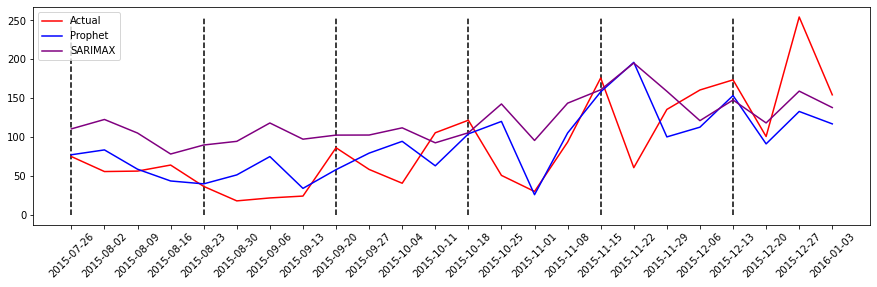

In [76]:
validation_lines=[test_comp["ds"].iloc[4*n] for n in range(int(test_comp["ds"].shape[0]/4))]
###tener en cuenta en el dibujo q serian las 4 primeras , osea el 26,2,9,16
plt.figure(figsize=(15,4)) ###ploteo solo el ultimo caso (cuando entrena con más datos)
plt.plot(test_comp["ds"] ,test_comp["y"], label='Actual', c="red")
plt.plot(test_comp["ds"], y_pred_comp_Prophet, label='Prophet', c="blue")
plt.plot(test_comp["ds"], y_pred_comp_SARIMAX, label='SARIMAX',c="purple")    
plt.xticks(rotation = 45)
plt.vlines(validation_lines, 0, max(test_comp["y"]), linestyles='dashed', colors='black')

plt.legend()
plt.show()

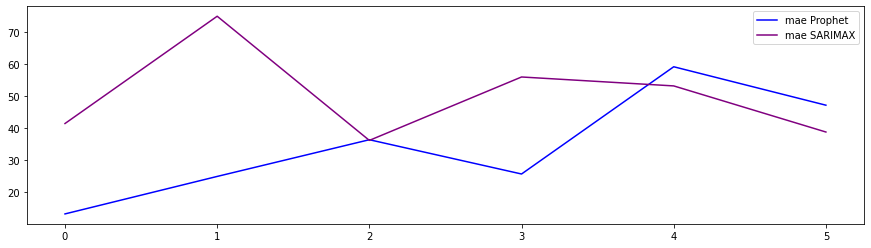

In [77]:
plt.figure(figsize=(15,4)) ###ploteo solo el ultimo caso (cuando entrena con más datos)
plt.plot(range(0,len(mae_Prophet)), mae_Prophet, label='mae Prophet', c="blue")
plt.plot(range(0,len(mae_Prophet)), mae_SARIMAX, label='mae SARIMAX',c="purple")    
plt.legend()
plt.show()